# DGE analyses for **anther** using `r-sleuth`
In this notebook, DGE-analyses for **anther vs all-other-tissues** are prepared:
 * 1. anther/stamen wt vs all-flower: subsampling only flower samples
         - `null = dataset`
         - `full = dataset+is_anther[yes-no]`
 * 2. anther wt vs anther mutants: subsampling only anther/stamen samples
     - `null = dataset`
     - `full = dataset+is_mutant[yes-no]`

## Import and prepare data

In [2]:
library(sleuth, warn.conflicts = FALSE)
library(tidyverse, warn.conflicts = FALSE)
library(cowplot, warn.conflicts = FALSE)
library(RColorBrewer, warn.conflicts = FALSE)
library(vsn)
library(pheatmap)
library(shiny)
theme_set(theme_bw())

In [3]:
set.seed(42) # For reproducibility of results

In [4]:
# import metadata
setwd("/home/vanda.marosi/floral_development_thesis_vm/datatables/")
# stringsAsfactors has to be truse for deseq2 design
barley_metadata <- read.table("barley_final.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)
barley_meta <- select(barley_metadata, Run.ID, Dataset, Batch, Cultivar, GM, Zadok_scale, Intermediate_age, High_level_age, Intermediate_tissue, High_level_tissue, Treatment, RNA_extraction, RNA_enrichment, RNA_input..microg., PCR_purification, Growth_condition, Day_night_condition, Temperature_day_night_c, Growth_location, Seq_location, Instrument, Library.layout)
colnames(barley_meta) <- c("ID", "dataset", "batch", "cultivar", "gm", "zadoc_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")
# exclude outliers detected during exploratory analyses: ERR781040, ERR1457187
barley_meta <- filter(barley_meta, ID != "ERR781040")
barley_meta <- filter(barley_meta, ID != "ERR1457187")
# exclude outliers detected during first sleuth runs: ERR1457171, ERR1457170, they are from developmental dataset, rachis/grain samples
barley_meta <- filter(barley_meta, ID != "ERR1457171")
barley_meta <- filter(barley_meta, ID != "ERR1457170")
# add rownames for deseq2 to identify rows with count-columns
rownames(barley_meta) <- barley_meta$ID
glimpse(barley_meta)

Rows: 236
Columns: 22
$ ID                  <chr> "ERR781039", "ERR781041", "ERR781042", "ERR781043…
$ dataset             <chr> "photoperiod_mutant_preanthesis", "photoperiod_mu…
$ batch               <int> 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 6, 7…
$ cultivar            <chr> "S42-IL107", "S42-IL107", "Scarlett", "Scarlett",…
$ gm                  <chr> "wt", "wt", "mut", "mut", "mut", "wt", "wt", "wt"…
$ zadoc_scale         <int> 9, 9, 11, 11, 11, 11, 11, 11, 14, 14, 14, 14, 14,…
$ intermediate_age    <chr> "Germination", "Germination", "Leaf_development",…
$ high_level_age      <chr> "Seedling", "Seedling", "Vegetative", "Vegetative…
$ intermediate_tissue <chr> "apex", "apex", "apex", "apex", "apex", "apex", "…
$ high_level_tissue   <chr> "meristem", "meristem", "meristem", "meristem", "…
$ treatment           <chr> "control", "control", "mutant", "mutant", "mutant…
$ rna_extraction      <chr> "trizol", "trizol", "trizol", "trizol", "trizol",…
$ rna_enrichment      <chr> "R

# 1. Anther contrast: **anther/stamen wt vs all-flower**
## 1.1 Create contrast variables
 * **is_anther:** yes = only anther wt tissues, no = flower tissues
 * first subsampling only flower samples!
 * modells:
         - `null = dataset`
         - `full = dataset+is_anther[yes-no]`

In [12]:
# here filter to flower tissues only
is_flower <- barley_meta %>% filter(high_level_tissue == "inflorescence") %>% select(ID, dataset, intermediate_tissue, gm) 
# here we select samples that are anther/stamen tissue
is_anther <- is_flower %>% filter(intermediate_tissue == "anther" | intermediate_tissue == "stamen") %>% 
                                              add_column(is_anther = "yes") %>% 
                                              select(ID, dataset, is_anther, gm)
# here we filter for wt-anther samples only
is_anther_yes <- is_anther %>% filter(gm == "wt") %>% select(ID, dataset, is_anther)
# here we select samples that are not anther/stamen, but are flower
is_anther_no <- is_flower %>% filter(intermediate_tissue != "anther" & intermediate_tissue != "stamen") %>% 
                                              add_column(is_anther = "no") %>% 
                                              select(ID, dataset, is_anther)
# here we join tables of anther or not into one table
barley_anther1 <- bind_rows(is_anther_yes, is_anther_no)
barley_anther1$ID <- as.factor(barley_anther1$ID)
barley_anther1$dataset <- as.factor(barley_anther1$dataset)
barley_anther1$is_anther <- as.factor(barley_anther1$is_anther)
glimpse(is_flower)
glimpse(is_anther)
glimpse(is_anther_yes)
glimpse(is_anther_no)
glimpse(barley_anther1)
tail(barley_anther1, 3)

Rows: 116
Columns: 4
$ ID                  <chr> "ERR1248084", "ERR1248085", "ERR1248086", "ERR124…
$ dataset             <chr> "drought", "drought", "drought", "drought", "drou…
$ intermediate_tissue <chr> "spike", "spike", "spike", "spike", "spike", "spi…
$ gm                  <chr> "wt", "wt", "wt", "wt", "wt", "wt", "wt", "wt", "…
Rows: 18
Columns: 4
$ ID        <chr> "SRR9889989", "SRR9889990", "SRR9889991", "SRR9889992", "SR…
$ dataset   <chr> "meiosis", "meiosis", "meiosis", "meiosis", "meiosis", "mei…
$ is_anther <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", "yes", "ye…
$ gm        <chr> "wt", "wt", "wt", "wt", "wt", "wt", "wt", "wt", "wt", "wt",…
Rows: 15
Columns: 3
$ ID        <chr> "SRR9889989", "SRR9889990", "SRR9889991", "SRR9889992", "SR…
$ dataset   <chr> "meiosis", "meiosis", "meiosis", "meiosis", "meiosis", "mei…
$ is_anther <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", "yes", "ye…
Rows: 98
Columns: 3
$ ID        <chr> "ERR1248084", "ERR1248085", "ERR

,ID,dataset,is_anther
,<fct>,<fct>,<fct>
111,ERR515195,laxatum_mutant,no
112,ERR515196,laxatum_mutant,no
113,ERR515197,laxatum_mutant,no


In [13]:
# load tx2gene object for mRNA mapping information
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
m <- read.delim("barley_tx2gene.tsv",stringsAsFactors=FALSE)
colnames(m) <- c("target_id", "gene")
head(m, 3)
dim(m)

,target_id,gene
,<chr>,<chr>
1,Horvu_MOREX_1H01G000100.1,Horvu_MOREX_1H01G000100
2,Horvu_MOREX_1H01G000200.1,Horvu_MOREX_1H01G000200
3,Horvu_MOREX_1H01G000300.1,Horvu_MOREX_1H01G000300


[1] 49281     2

In [14]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", barley_anther1$ID, "abundance.h5")
names(files) <- paste0(barley_anther1$ID)
head(files)
all(file.exists(files))

SRR9889989 
"../04_Kallisto_allreads_symlinked/SRR9889989/abundance.h5" 
                                                 SRR9889990 
"../04_Kallisto_allreads_symlinked/SRR9889990/abundance.h5" 
                                                 SRR9889991 
"../04_Kallisto_allreads_symlinked/SRR9889991/abundance.h5" 
                                                 SRR9889992 
"../04_Kallisto_allreads_symlinked/SRR9889992/abundance.h5" 
                                                 SRR9889993 
"../04_Kallisto_allreads_symlinked/SRR9889993/abundance.h5" 
                                                 SRR9889994 
"../04_Kallisto_allreads_symlinked/SRR9889994/abundance.h5"

[1] TRUE

In [15]:
s2c_anther1 <- mutate(barley_anther1, path = files, sample = ID)
head(s2c_anther1, 3)

,ID,dataset,is_anther,path,sample
,<fct>,<fct>,<fct>,<chr>,<fct>
1,SRR9889989,meiosis,yes,../04_Kallisto_allreads_symlinked/SRR9889989/abundance.h5,SRR9889989
2,SRR9889990,meiosis,yes,../04_Kallisto_allreads_symlinked/SRR9889990/abundance.h5,SRR9889990
3,SRR9889991,meiosis,yes,../04_Kallisto_allreads_symlinked/SRR9889991/abundance.h5,SRR9889991


In [16]:
# construct the sleuth-object
so_anther1 <- sleuth_prep(sample_to_covariates = s2c_anther1, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
.................................................................................................................
normalizing est_counts
20832 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
20832 genes passed the filter
summarizing bootstraps
.................................................
..................................................
..............


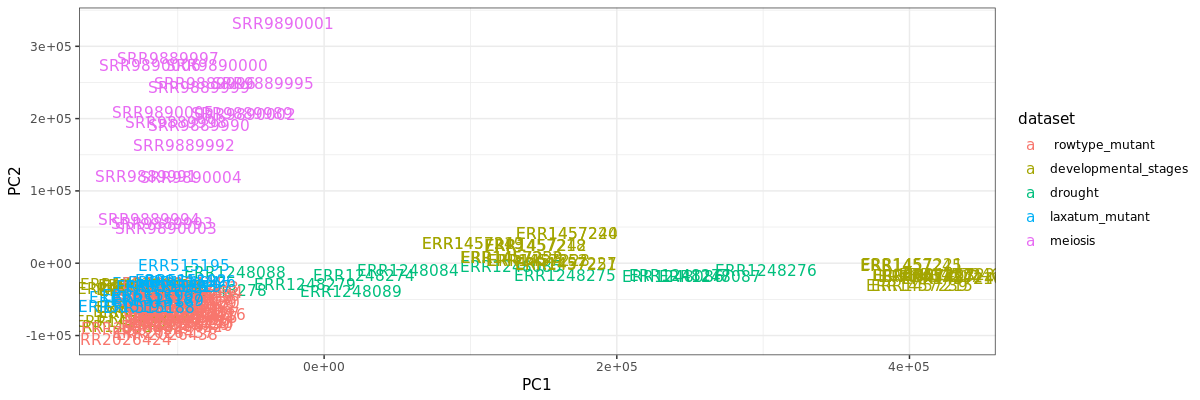

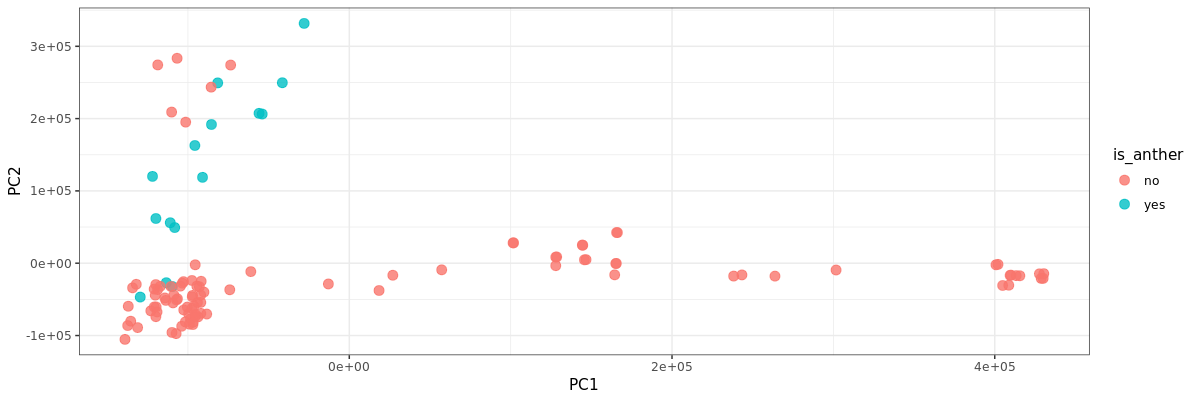

In [17]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_anther1, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_anther1, color_by = 'is_anther',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

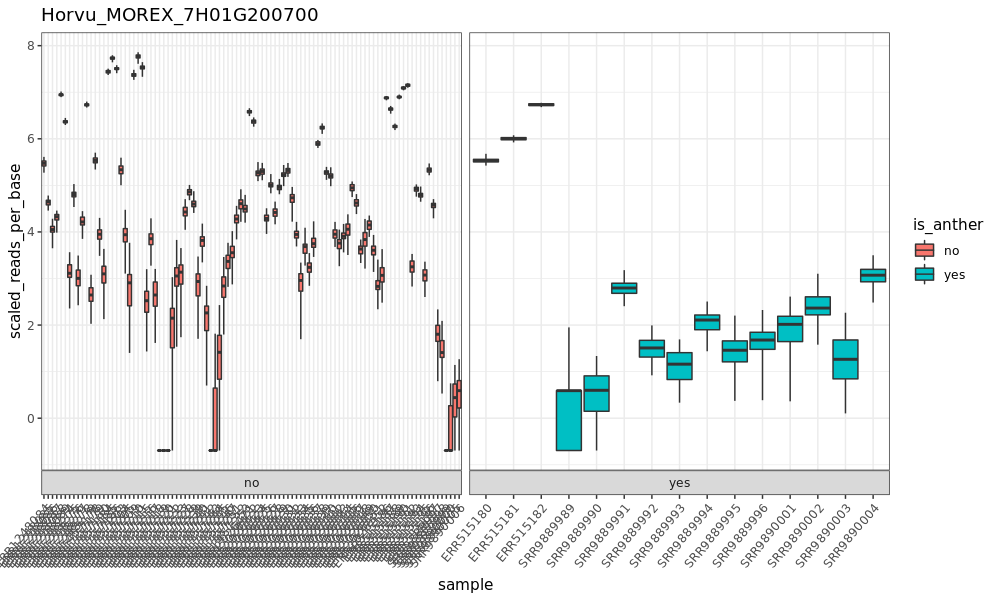

In [19]:
# check for bootstrapping
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
plot_bootstrap(so_anther1, 'Horvu_MOREX_7H01G200700', color_by = 'is_anther',units='scaled_reads_per_base')

In [20]:
# create models
so_anther1 <- sleuth_fit(so_anther1, ~dataset + is_anther, 'full')
so_anther1 <- sleuth_fit(so_anther1, ~dataset, 'reduced')

fitting measurement error models
shrinkage estimation
2 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_1H01G013900, Horvu_MOREX_5H01G096000
computing variance of betas
fitting measurement error models
shrinkage estimation
2 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_1H01G013900, Horvu_MOREX_5H01G096000
computing variance of betas


In [21]:
# perform DGE test
so_anther1 <- sleuth_lrt(so_anther1, 'reduced', 'full')

In [22]:
models(so_anther1)

[  full  ]
formula:  ~dataset + is_anther 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis
 	is_antheryes
[  reduced  ]
formula:  ~dataset 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis


In [23]:
table_anther1 <- sleuth_results(so_anther1, 'reduced:full', 'lrt', show_all = FALSE)
sig_anther1_1 <- filter(table_anther1, qval <= 0.1)
glimpse(sig_anther1_1)
sig_anther1_05 <- filter(table_anther1, qval <= 0.05)
glimpse(sig_anther1_05)
sig_anther1_01 <- filter(table_anther1, qval <= 0.01)
glimpse(sig_anther1_01)
# look at table and few of 0.05
head(sig_anther1_05, 5)

Rows: 3,205
Columns: 12
$ target_id       <chr> "Horvu_MOREX_7H01G228600", "Horvu_MOREX_3H01G567300",…
$ pval            <dbl> 1.269423e-14, 8.951077e-13, 1.038055e-12, 2.182448e-1…
$ qval            <dbl> 2.644462e-10, 7.208256e-09, 7.208256e-09, 1.136619e-0…
$ test_stat       <dbl> 59.42659, 51.06163, 50.77082, 49.31270, 46.23154, 43.…
$ rss             <dbl> 10.025857, 21.357566, 26.000716, 23.500416, 11.771672…
$ degrees_free    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ mean_obs        <dbl> 7.250265, 6.084258, 8.197271, 6.373257, 7.919415, 6.1…
$ var_obs         <dbl> 0.1168390, 0.5467039, 0.3359195, 0.3756621, 0.1611710…
$ tech_var        <dbl> 0.0008755747, 0.0029299308, 0.0003465482, 0.002352120…
$ sigma_sq        <dbl> 0.09195644, 0.19482531, 0.24040083, 0.21524432, 0.108…
$ smooth_sigma_sq <dbl> 0.08127084, 0.11955781, 0.07833922, 0.10532363, 0.077…
$ final_sigma_sq  <dbl> 0.09195644, 0.19482531, 0.24040083, 0.21524432, 0.108…
Rows: 1,968
Columns: 12
$ ta

,target_id,pval,qval,test_stat,rss,degrees_free,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_7H01G228600,1.269423e-14,2.644462e-10,59.42659,10.02586,1,7.250265,0.1168390,0.0008755747,0.09195644,0.08127084,0.09195644
2,Horvu_MOREX_3H01G567300,8.951077e-13,7.208256e-09,51.06163,21.35757,1,6.084258,0.5467039,0.0029299308,0.19482531,0.11955781,0.19482531
3,Horvu_MOREX_7H01G474200,1.038055e-12,7.208256e-09,50.77082,26.00072,1,8.197271,0.3359195,0.0003465482,0.24040083,0.07833922,0.24040083
4,Horvu_MOREX_2H01G591300,2.182448e-12,1.136619e-08,49.31270,23.50042,1,6.373257,0.3756621,0.0023521208,0.21524432,0.10532363,0.21524432
5,Horvu_MOREX_3H01G255800,1.050718e-11,4.377711e-08,46.23154,11.77167,1,7.919415,0.1611710,0.0004930552,0.10850391,0.07726612,0.10850391


In [24]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig_anther1_1, file = "deg_anther1_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig_anther1_05, file = "deg_anther1_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig_anther1_01, file = "deg_anther1_signif0_01.csv", sep = ",", col.names = TRUE)

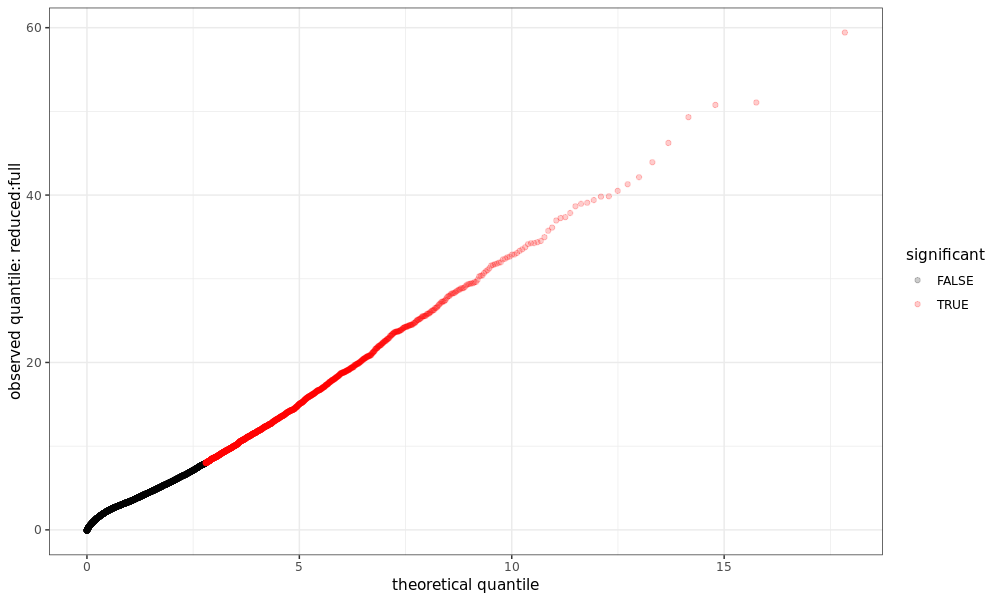

In [25]:
plot_qq(so_anther1, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

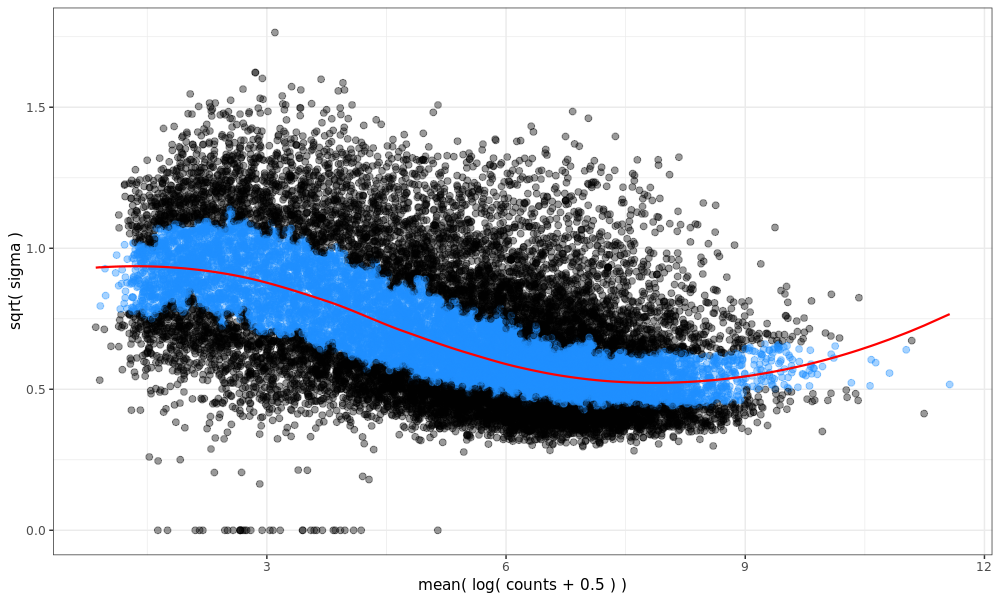

In [26]:
plot_mean_var(so_anther1,which_model="full")

# 2. Anther contrast: **anther wt vs anther mutants**
## 2.1 Create contrast variables
 * **is_mutant:** yes = only anther/stamen wt tissues, no = only anther/stamen mutant tissues
 * first subsampling only anther/stamen samples!
 * modells:
     - `null = dataset`
     - `full = dataset+is_mutant[yes-no]`

In [27]:
# here filter for anther tissues only
is_anther <- barley_meta %>% filter(intermediate_tissue == "anther" | intermediate_tissue == "stamen") %>% select(ID, dataset, gm) 
# here we select mutants
is_mutant_yes <- is_anther %>% filter(gm == "mut") %>% 
                            add_column(is_mutant = "yes") %>% 
                            select(ID, dataset, is_mutant)
# here we select wild types
is_mutant_no <- is_anther %>% filter(gm == "wt") %>% 
                            add_column(is_mutant = "no") %>% 
                            select(ID, dataset, is_mutant)
# here we join tables of mutant or not into one table
barley_anther2 <- bind_rows(is_mutant_yes, is_mutant_no)
barley_anther2$ID <- as.factor(barley_anther2$ID)
barley_anther2$dataset <- as.factor(barley_anther2$dataset)
barley_anther2$is_mutant <- as.factor(barley_anther2$is_mutant)
glimpse(is_anther)
glimpse(is_mutant_yes)
glimpse(is_mutant_no)
glimpse(barley_anther2)
tail(barley_anther2, 3)

Rows: 18
Columns: 3
$ ID      <chr> "SRR9889989", "SRR9889990", "SRR9889991", "SRR9889992", "SRR9…
$ dataset <chr> "meiosis", "meiosis", "meiosis", "meiosis", "meiosis", "meios…
$ gm      <chr> "wt", "wt", "wt", "wt", "wt", "wt", "wt", "wt", "wt", "wt", "…
Rows: 3
Columns: 3
$ ID        <chr> "ERR515183", "ERR515184", "ERR515185"
$ dataset   <chr> "laxatum_mutant", "laxatum_mutant", "laxatum_mutant"
$ is_mutant <chr> "yes", "yes", "yes"
Rows: 15
Columns: 3
$ ID        <chr> "SRR9889989", "SRR9889990", "SRR9889991", "SRR9889992", "SR…
$ dataset   <chr> "meiosis", "meiosis", "meiosis", "meiosis", "meiosis", "mei…
$ is_mutant <chr> "no", "no", "no", "no", "no", "no", "no", "no", "no", "no",…
Rows: 18
Columns: 3
$ ID        <fct> ERR515183, ERR515184, ERR515185, SRR9889989, SRR9889990, SR…
$ dataset   <fct> laxatum_mutant, laxatum_mutant, laxatum_mutant, meiosis, me…
$ is_mutant <fct> yes, yes, yes, no, no, no, no, no, no, no, no, no, no, no, …


,ID,dataset,is_mutant
,<fct>,<fct>,<fct>
16,ERR515180,laxatum_mutant,no
17,ERR515181,laxatum_mutant,no
18,ERR515182,laxatum_mutant,no


In [28]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", barley_anther2$ID, "abundance.h5")
names(files) <- paste0(barley_anther2$ID)
head(files)
all(file.exists(files))

ERR515183 
 "../04_Kallisto_allreads_symlinked/ERR515183/abundance.h5" 
                                                  ERR515184 
 "../04_Kallisto_allreads_symlinked/ERR515184/abundance.h5" 
                                                  ERR515185 
 "../04_Kallisto_allreads_symlinked/ERR515185/abundance.h5" 
                                                 SRR9889989 
"../04_Kallisto_allreads_symlinked/SRR9889989/abundance.h5" 
                                                 SRR9889990 
"../04_Kallisto_allreads_symlinked/SRR9889990/abundance.h5" 
                                                 SRR9889991 
"../04_Kallisto_allreads_symlinked/SRR9889991/abundance.h5"

[1] TRUE

In [29]:
s2c_anther2 <- mutate(barley_anther2, path = files, sample = ID)
head(s2c_anther2, 3)

,ID,dataset,is_mutant,path,sample
,<fct>,<fct>,<fct>,<chr>,<fct>
1,ERR515183,laxatum_mutant,yes,../04_Kallisto_allreads_symlinked/ERR515183/abundance.h5,ERR515183
2,ERR515184,laxatum_mutant,yes,../04_Kallisto_allreads_symlinked/ERR515184/abundance.h5,ERR515184
3,ERR515185,laxatum_mutant,yes,../04_Kallisto_allreads_symlinked/ERR515185/abundance.h5,ERR515185


In [30]:
# construct the sleuth-object
so_anther2 <- sleuth_prep(sample_to_covariates = s2c_anther2, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
..................
normalizing est_counts
21997 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
21997 genes passed the filter
summarizing bootstraps
..................


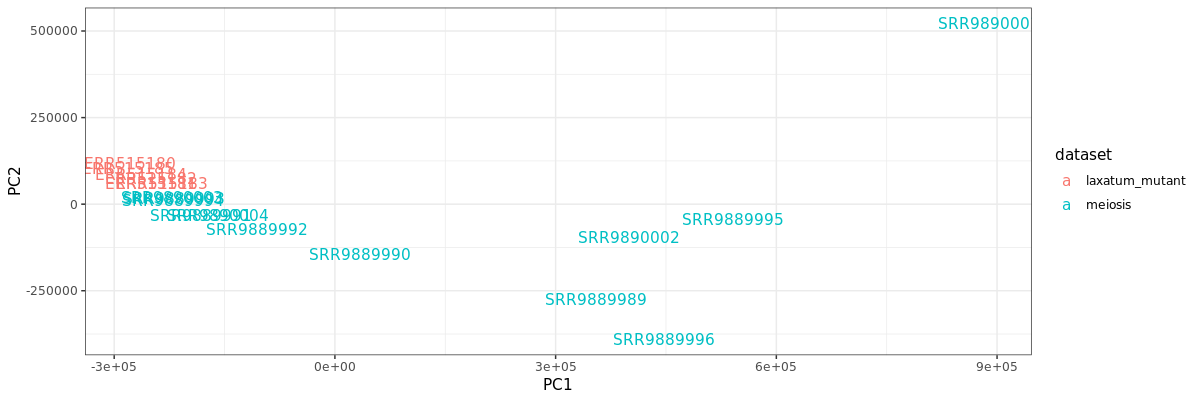

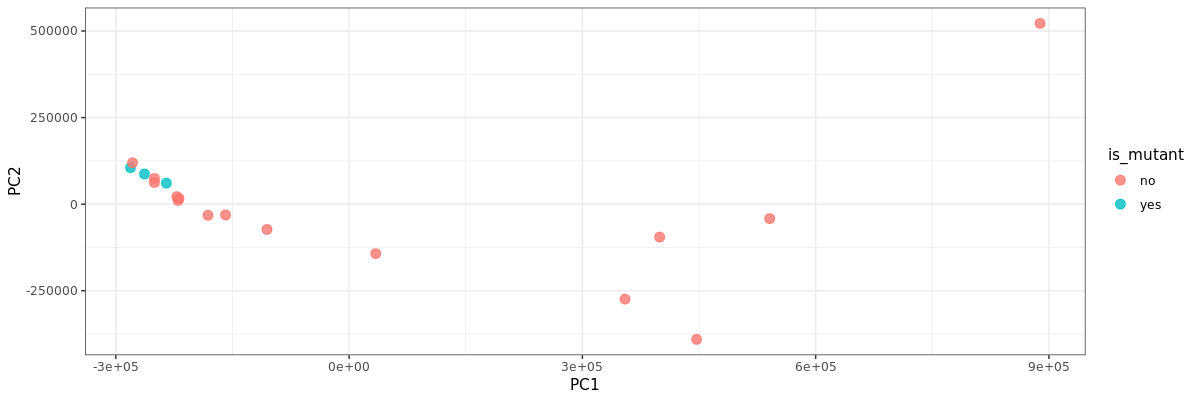

In [31]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_anther2, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_anther2, color_by = 'is_mutant',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

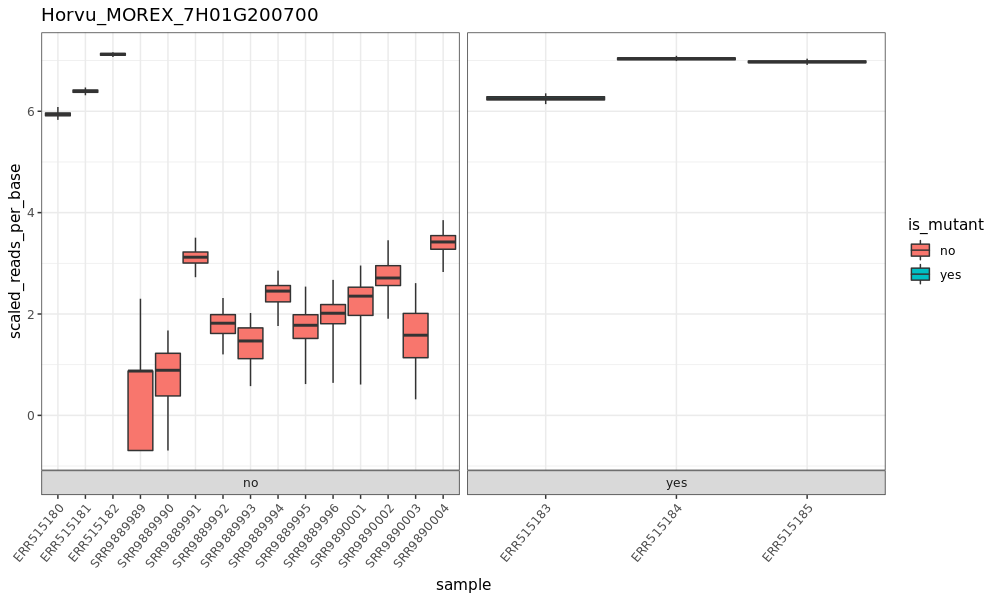

In [32]:
# check for bootstrapping
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
plot_bootstrap(so_anther2, 'Horvu_MOREX_7H01G200700', color_by = 'is_mutant',units='scaled_reads_per_base')

In [33]:
# create models
so_anther2 <- sleuth_fit(so_anther2, ~dataset + is_mutant, 'full')
so_anther2 <- sleuth_fit(so_anther2, ~dataset, 'reduced')

fitting measurement error models
shrinkage estimation
1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_5H01G674500
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [34]:
# perform DGE test
so_anther2 <- sleuth_lrt(so_anther2, 'reduced', 'full')

In [35]:
models(so_anther2)

[  full  ]
formula:  ~dataset + is_mutant 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetmeiosis
 	is_mutantyes
[  reduced  ]
formula:  ~dataset 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetmeiosis


In [36]:
table_anther2 <- sleuth_results(so_anther2, 'reduced:full', 'lrt', show_all = FALSE)
sig_anther2_1 <- filter(table_anther2, qval <= 0.1)
glimpse(sig_anther2_1)
sig_anther2_05 <- filter(table_anther2, qval <= 0.05)
glimpse(sig_anther2_05)
sig_anther2_01 <- filter(table_anther2, qval <= 0.01)
glimpse(sig_anther2_01)
# look at table and few of 0.05
head(sig_anther2_05, 5)

Rows: 71
Columns: 12
$ target_id       <chr> "Horvu_MOREX_5H01G243000", "Horvu_MOREX_5H01G026800",…
$ pval            <dbl> 2.590743e-19, 9.147793e-19, 9.217007e-18, 8.810797e-1…
$ qval            <dbl> 5.698858e-15, 1.006120e-14, 6.758216e-14, 4.845278e-1…
$ test_stat       <dbl> 80.72763, 78.23511, 73.67346, 69.21916, 66.57165, 63.…
$ rss             <dbl> 83.41609, 34.54508, 70.23847, 48.44899, 42.42660, 53.…
$ degrees_free    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ mean_obs        <dbl> 5.989774, 6.850103, 5.571107, 6.717375, 5.044611, 3.6…
$ var_obs         <dbl> 8.5174524, 2.8185037, 7.5439890, 3.9365488, 7.6066399…
$ tech_var        <dbl> 0.025031107, 0.005692801, 0.021458728, 0.018869312, 0…
$ sigma_sq        <dbl> 5.1884743, 2.1533749, 4.3684455, 3.0091926, 2.6491783…
$ smooth_sigma_sq <dbl> 0.05714074, 0.04356781, 0.06899998, 0.04486843, 0.090…
$ final_sigma_sq  <dbl> 5.1884743, 2.1533749, 4.3684455, 3.0091926, 2.6491783…
Rows: 65
Columns: 12
$ target_i

,target_id,pval,qval,test_stat,rss,degrees_free,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_5H01G243000,2.590743e-19,5.698858e-15,80.72763,83.41609,1,5.989774,8.517452,0.025031107,5.188474,0.05714074,5.188474
2,Horvu_MOREX_5H01G026800,9.147793e-19,1.006120e-14,78.23511,34.54508,1,6.850103,2.818504,0.005692801,2.153375,0.04356781,2.153375
3,Horvu_MOREX_5H01G030000,9.217007e-18,6.758216e-14,73.67346,70.23847,1,5.571107,7.543989,0.021458728,4.368445,0.06899998,4.368445
4,Horvu_MOREX_5H01G026900,8.810797e-17,4.845278e-13,69.21916,48.44899,1,6.717375,3.936549,0.018869312,3.009193,0.04486843,3.009193
5,Horvu_MOREX_6H01G124100,3.374045e-16,1.484377e-12,66.57165,42.42660,1,5.044611,7.606640,0.002483952,2.649178,0.09060120,2.649178


In [37]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig_anther2_1, file = "deg_anther2_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig_anther2_05, file = "deg_anther2_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig_anther2_01, file = "deg_anther2_signif0_01.csv", sep = ",", col.names = TRUE)

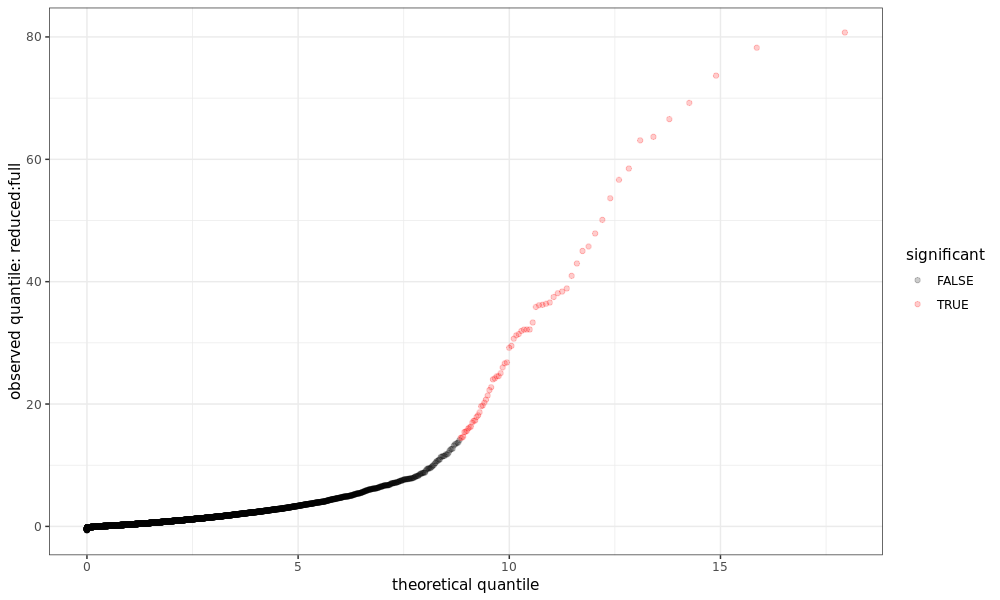

In [38]:
plot_qq(so_anther2, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

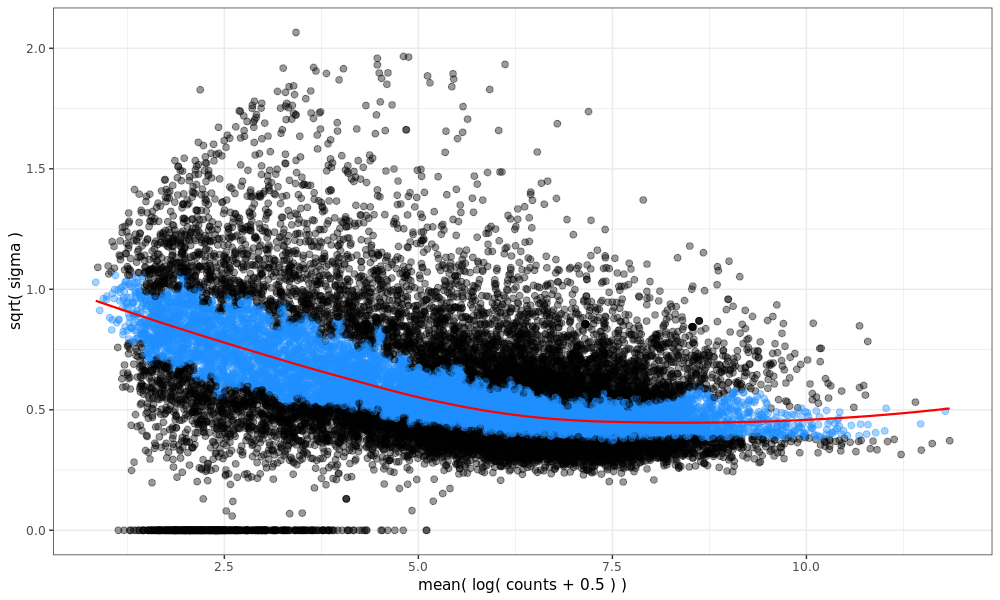

In [39]:
plot_mean_var(so_anther2,which_model="full")

In [40]:
sleuth_live_settings(test_type = "lrt")
sleuth_live(so_anther2, settings = sleuth_live_settings())
# in order to display: open new terminal tab and type: `ssh -L localhost:42427:localhost:42427 vanda.marosi@bee`
# number after localhost has to match the last number written in the output
# after this, copy and enter http site address 

$test_type
[1] "lrt"


Listening on http://127.0.0.1:42427
Warning message:
“Error in plot_transcript_heatmap: Couldn't find the following transcripts: <div, id="default_top_ten", class="shiny-text-output"></div>
	It is highly likely that some of them were filtered out.”Warning message:
“Error in as.data.frame.default: cannot coerce class ‘c("quosure", "formula")’ to a data.frame”

In [41]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/vanda.marosi/anaconda3/envs/r/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] shiny_1.3.2         pheatmap_1.0.12     vsn_3.54.0         
 [4] Biobase_2.46.0      BiocGenerics_0.32.0 RColorBrewer_1.1-2 
 [7] cowplot_1.0.0       forcats_0.5.0       stringr_1.4.0      
[10] dplyr_0.8.5         purrr_0.3.4         readr_1.3.1        
[13] tidyr_1.0.2       